# fig3

## Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import scvelo as scv
import sctk as sk
import cellrank as cr

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from sklearn.preprocessing import minmax_scale
import plotnine as pln
from plotnine import ggplot, aes
from pathlib import Path

## Load data

In [2]:
data_root = Path('/lustre/scratch126/cellgen/team205/nh3/skin').resolve()
proj_root = Path('~/FCA_Fetal_Skin_priv/').expanduser()
os.chdir(proj_root)
!pwd

/home/jovyan/FCA_Fetal_Skin_priv


In [3]:
fetal_h5ad = Path(data_root, "20210611_final_object/fetal_skin.norm.maternal_removed.20220202.h5ad")

In [4]:
fsk_ms_h5ad = Path(data_root, "20210611_final_object/cellxgene_h5ad/20220202/fetal_skin.stroma.cellxgene.20220202.h5ad")

In [5]:
pooled_ms_h5ad = Path(data_root, "20200626_make_figure_for_Muzz/pooled_mesenchymal.processed.h5ad")

In [6]:
fetal_ad0 = sc.read(fetal_h5ad, backed="r")

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [7]:
fetal_ms_ad0 = sc.read(fsk_ms_h5ad, backed="r")

Only considering the two last: ['.20220202', '.h5ad'].
Only considering the two last: ['.20220202', '.h5ad'].


In [8]:
pooled_ms_ad0 = sc.read(pooled_ms_h5ad)

In [9]:
color_codes = {
    "HOXC5+ early fibroblast": "#BB7784",
    "FRZB+ early fibroblast": "#D6BDC1",
    "Pre-dermal condensate": "#EAD3C7",
    "Dermal condensate": "#7C87B9",
    "Dermal papillia": "#BFC1D4",
    "WNT2+ fibroblast": "#29B8C9", # changed from "#4B68B0"
    "PEAR1+ fibroblast": "#8794CA",
    "Adipocytes": "#154496",
    "Mural cell pericytes": "#C7DFC7",
    "Myoblasts": "#E6AFBA",
    "Early myocytes": "#8F143E",
    "Myocytes": "#E07B91",
}

In [10]:
fetal_ms_ad0.obs["independent_annotation_refined_20220823"] = sk.regroup(
    fetal_ms_ad0,
    groupby="independent_annotation_refined_20220202",
    regroups={
        "Mural cell pericyte": "Pericytes",
        "SPP1+ proliferating neuron progenitors": "SPP1+ proliferating neuron proneitors",
        "PID1+ Schwann cells": "PID1+ schwann cellls",
    },
)

In [11]:
fetal_ms_ad0.obs.independent_annotation_refined_20220823.cat.categories

Index(['Adipocytes', 'Dermal condensate', 'Dermal papillia', 'Early myocytes',
       'FRZB+ early fibroblast', 'HOXC5+ early fibroblast',
       'LMCD1+ mural cell', 'Mural cell pericyte', 'Myelinating Schwann cells',
       'Myoblasts', 'Myocytes', 'Myofibroblasts', 'Neuroendocrine',
       'Neuron progenitors', 'PEAR1+ fibroblast', 'PID1+ Schwann cells',
       'PLN+ mural cell', 'Pre-dermal condensate',
       'SPP1+ proliferating neuron progenitors', 'Schwann/Schwann precursors',
       'WNT2+ fibroblast'],
      dtype='object')

In [12]:
fetal_ms_ad0.obs.independent_annotation_refined_20220823.cat.categories.size

21

In [13]:
full_color_codes = {
    "Neuron progenitors": "#92C892",
    "Neuroendocrine": "#47AD3D",
    "SPP1+ proliferating neuron progenitors": "#F1B98D",
    "Myelinating Schwann cells": "#B6BCE0",
    "Schwann/Schwann precursors": "#47B9B5",
    "PID1+ Schwann cells": "#F09709",
    "Adipocytes": "#154496",
    "Dermal papillia": "#BFC1D4",
    "Dermal condensate": "#7C87B9",
    "PEAR1+ fibroblast": "#8693CA",
    "WNT2+ fibroblast": "#29B8C9", # Changed from "#4B68B0"
    "HOXC5+ early fibroblast": "#BB7784",
    "FRZB+ early fibroblast": "#D6BDC1",
    "Pre-dermal condensate": "#EAD3C7",
    "Myofibroblasts": "#D43D6A",
    "Early myocytes": "#8F153C",
    "Myocytes": "#E07A91",
    "Myoblasts": "#E7AFB9",
    "PLN+ mural cell": "#D6EAE7",
    "LMCD1+ mural cell": "#A0D5D1",
    "Mural cell pericyte": "#92C892",
}

## Process

### Check latest annotation

In [14]:
pooled_ms_ad0.obs_names[0:2]

Index(['GATCGTACATTCCTCG-1-4834STDY7002879-fetal_skin', 'ATTCTACTCTCCAACC-1-4834STDY7002880-fetal_skin'], dtype='object', name='index')

In [15]:
fetal_ad0.obs_names[0:2]

Index(['AAACCTGGTCAGTGGA-1-4834STDY7002879', 'AAAGATGGTCGATTGT-1-4834STDY7002879'], dtype='object', name='index')

In [16]:
k_fsk1 = (
    pooled_ms_ad0.obs.dataset == "fetal_skin"
) & pooled_ms_ad0.obs_names.to_series().str.replace("-fetal_skin", "").isin(fetal_ad0.obs_names)

In [17]:
k_fsk2 = (
    pooled_ms_ad0.obs.dataset == "fetal_skin"
) & ~pooled_ms_ad0.obs_names.to_series().str.replace("-fetal_skin", "").isin(fetal_ad0.obs_names)

In [18]:
k_fsk1.sum(), k_fsk2.sum()

(2530, 318)

In [19]:
pooled_ms_ad0.obs.loc[k_fsk1, "joint_annot_20220202"] = fetal_ad0.obs.loc[
    fetal_ad0.obs_names.isin(
        pooled_ms_ad0.obs_names[k_fsk1].to_series().str.replace("-fetal_skin", "")
    ),
    "joint_annotation_20220202",
].values

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


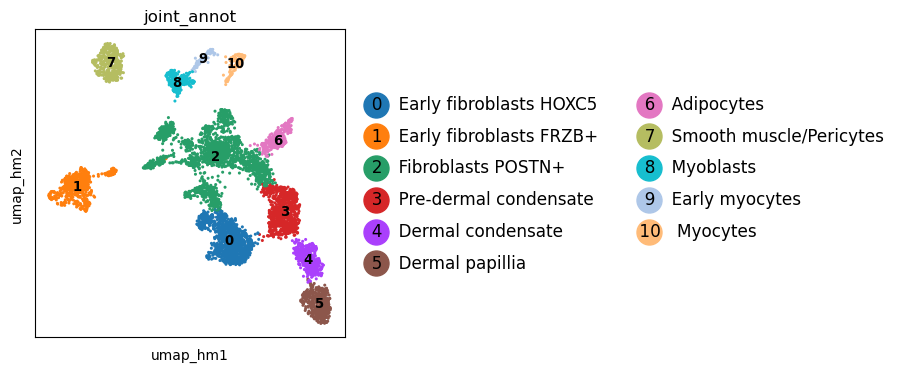

In [20]:
sk.plot_embedding(pooled_ms_ad0, groupby="joint_annot", basis="umap_hm");

Trying to set attribute `.uns` of view, copying.
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


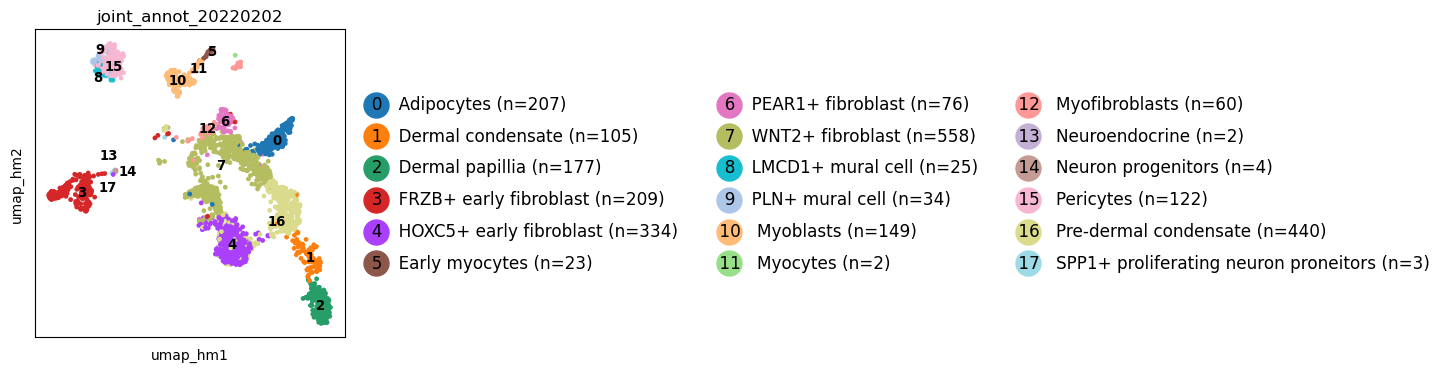

In [21]:
sk.plot_embedding(
    pooled_ms_ad0[pooled_ms_ad0.obs.joint_annot_20220202.astype(str) != "nan"],
    groupby="joint_annot_20220202",
    basis="umap_hm",
    annot="full",
);

### Separate PEAR1+ fibroblast and chondrocytes

In [22]:
pooled_ms_ad0

AnnData object with n_obs × n_vars = 6213 × 16797
    obs: 'batch', 'chemistry_sorting', 'dataset', 'day', 'donor', 'gender', 'n_counts', 'n_genes', 'nh3_annot1', 'percent_hb', 'percent_mito', 'percent_ribo', 'percent_top50', 'rachel_annot2', 'sample_id', 'strain', 'week', 'annot', 'leiden_hm_r0_1', 'leiden_hm_r0_3', 'leiden_hm_r0_5', 'leiden_hm_r0_7', 'leiden_hm_r0_9', 'joint_annot', 'joint_annot_20220202'
    var: 'gene_ids', 'hb', 'cc', 'mito', 'ribo', 'n_counts', 'n_cells', 'highly_variable', 'hvg_full'
    uns: 'leiden', 'neighbors', 'neighbors_hm', 'pca', 'joint_annot_colors'
    obsm: 'X_pca', 'X_pca_hm', 'X_umap_hm'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [23]:
pooled_ms_ad0.obsp["neighbors_hm_connectivities"] = pooled_ms_ad0.uns["neighbors_hm"][
    "connectivities"
].copy()
pooled_ms_ad0.obsp["neighbors_hm_distances"] = pooled_ms_ad0.uns["neighbors_hm"]["distances"].copy()

<span style="color:red">legacy modied to true</span>. Because ```pooled_ms_ad0.obsp``` shows ```connectivities``` as a key instead of ```connectivities_key```, which according to ```sctk/build/lib/sctk/_leiden.py:98``` must mean ```.../20200626_make_figure_for_Muzz/pooled_mesenchymal.processed.h5ad``` was produced using ```scanpy <= 1.4.x.``` 

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


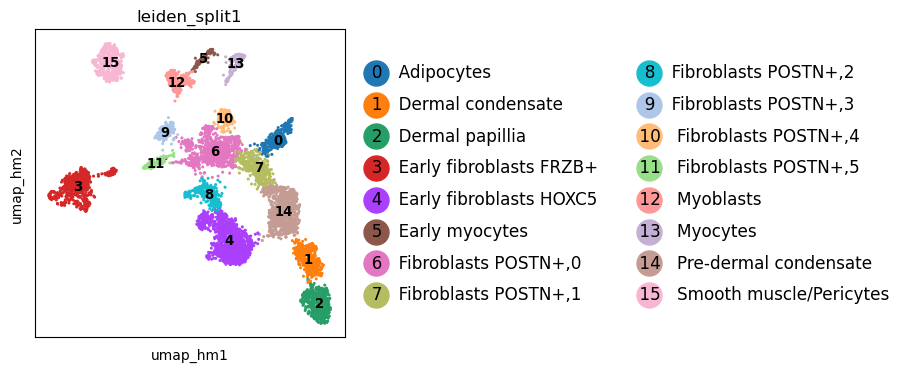

In [24]:
sk.leiden(
    pooled_ms_ad0,
    resolution=0.1,
    use_graph="neighbors_hm",
    restrict_to=("joint_annot", ("Fibroblasts POSTN+",)),
    key_added="leiden_split1", 
    legacy=True, # must be set to true for this dataset
)
sk.clear_colors(pooled_ms_ad0)
sk.plot_embedding(pooled_ms_ad0, basis="umap_hm", groupby="leiden_split1");

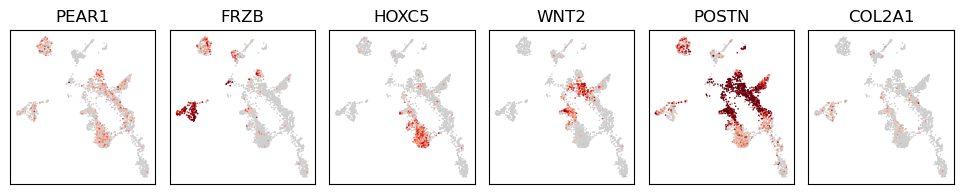

In [25]:
sk.plot_genes(
    pooled_ms_ad0[pooled_ms_ad0.obs.dataset == "fetal_skin"],
    genes=["PEAR1", "FRZB", "HOXC5", "WNT2", "POSTN", "COL2A1"],
    basis="umap_hm",
    size=5,
    vmin=0,
    vmax=3,
);

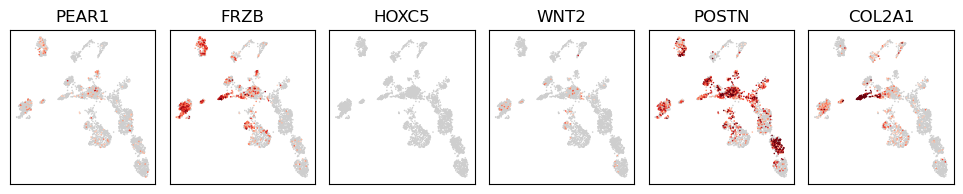

In [26]:
sk.plot_genes(
    pooled_ms_ad0[pooled_ms_ad0.obs.dataset == "organoid"],
    genes=["PEAR1", "FRZB", "HOXC5", "WNT2", "POSTN", "COL2A1"],
    basis="umap_hm",
    size=5,
    vmin=0,
    vmax=3,
);

### Re-label to match colors

In [27]:
fetal_ms_ad0.obs.independent_annotation_refined_20220823.cat.reorder_categories(
    list(full_color_codes.keys()),
    inplace=True,
)

In [28]:
pooled_ms_ad0.obs["joint_annot2"] = sk.regroup(
    pooled_ms_ad0,
    groupby="leiden_split1",
    regroups={
        "HOXC5+ early fibroblast": "Early fibroblasts HOXC5",
        "FRZB+ early fibroblast": "Early fibroblasts FRZB+",
        "WNT2+ fibroblast": [
            "Fibroblasts POSTN+,0",
            "Fibroblasts POSTN+,1",
            "Fibroblasts POSTN+,2",
            "Fibroblasts POSTN+,4",
        ],
        "PEAR1+ fibroblast": "Fibroblasts POSTN+,3",
        # "Chondrocytes": "Fibroblasts POSTN+,4",
        "Mural cell pericytes": "Smooth muscle/Pericytes",
    },
)

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


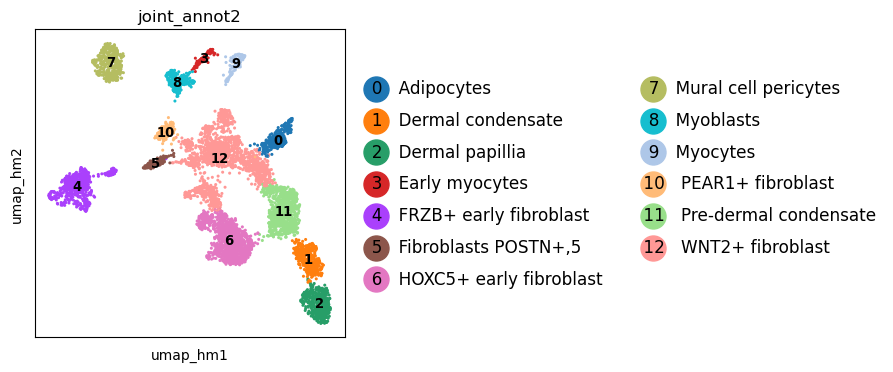

In [29]:
sk.clear_colors(pooled_ms_ad0)
sk.plot_embedding(pooled_ms_ad0, groupby="joint_annot2", basis="umap_hm");

In [30]:
for i, ct in enumerate(pooled_ms_ad0.obs.joint_annot2.cat.categories):
    if ct in color_codes:
        pooled_ms_ad0.uns["joint_annot2_colors"][i] = color_codes[ct]

Final relabelling mural cells

In [31]:
pooled_ms_ad0.obs.joint_annot2.cat.rename_categories(
    {"Mural cell pericytes": "Mural cells"}, inplace=True
)

## Plot

In [32]:
fetal_ms_ad0

AnnData object with n_obs × n_vars = 119610 × 28885 backed at '/lustre/scratch126/cellgen/team205/nh3/skin/20210611_final_object/cellxgene_h5ad/20220202/fetal_skin.stroma.cellxgene.20220202.h5ad'
    obs: 'sanger_id', 'chemistry', 'donor', 'gender', 'pcw', 'sorting', 'sample', 'chemistry_sorting', 'cell_caller', 'scrublet_score', 'cluster_scrublet_score', 'doublet_pval', 'bh_doublet_pval', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'percent_hb', 'independent_annotation_refined', 'independent_annotation_broad1', 'independent_annotation_broad2', 'independent_annotation_broad3', 'independent_annotation_broad4', 'independent_annotation_broad5', 'joint_annotation', 'is_maternal', 'fig1b_annotation', 'independent_annotation_refined_20220201a', 'independent_annotation_refined_20220201b', 'independent_annotation_broad1_20220201', 'independent_annotation_broad2_20220201', 'independent_annotation_broad3_20220201', 'joint_annotation_20220201a', 'joint_annotation_20220201b', 'fig1b_ann

In [33]:
sk.clear_colors(fetal_ms_ad0)
fetal_ms_ad0.uns["independent_annotation_refined_20220823_colors"] = [
    full_color_codes[ct]
    for ct in fetal_ms_ad0.obs.independent_annotation_refined_20220823.cat.categories
]

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


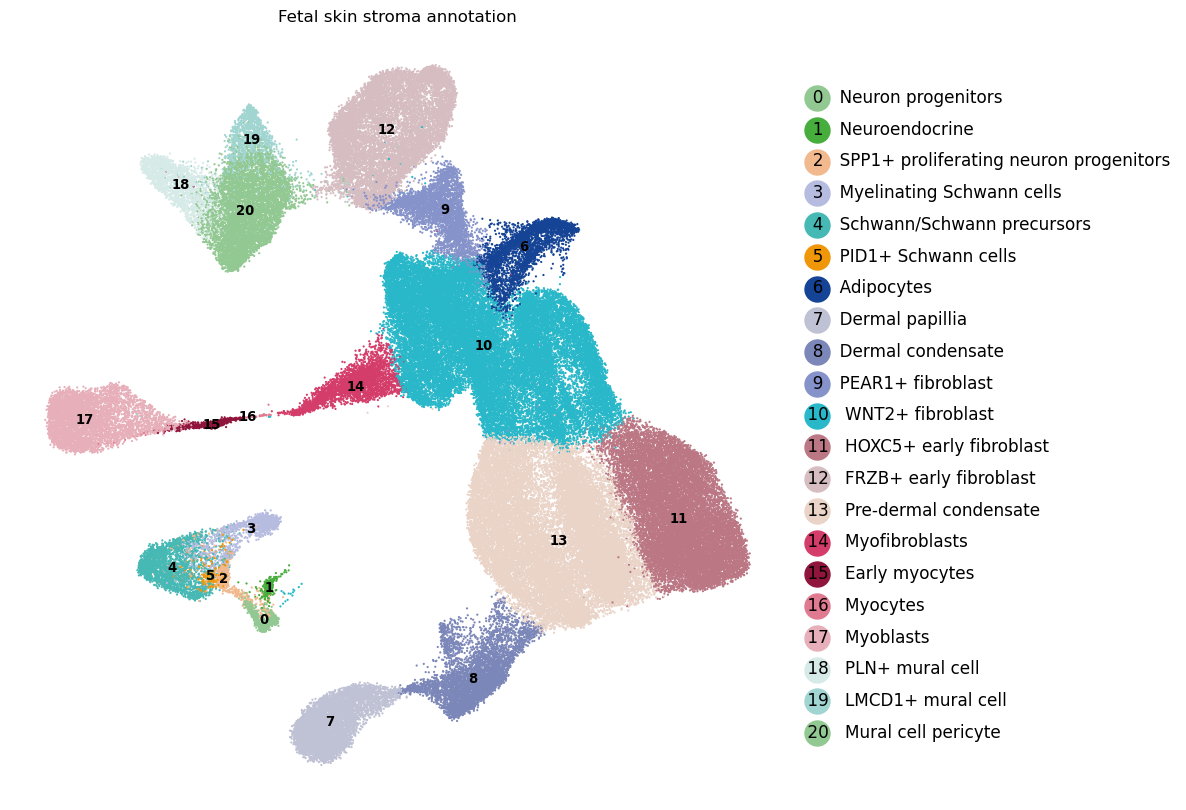

In [35]:
# sk.clear_colors(fetal_ms_ad0)
sk.plot_embedding(
    fetal_ms_ad0,
    basis="umap_bk",
    groupby="independent_annotation_refined_20220823",
    size=10,
    figsize=(10, 10),
    title="Fetal skin stroma annotation",
    legend_fontsize=11,
    frameon=False,
    save="figures/fig3A_color_updated.20220823.pdf",
);

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


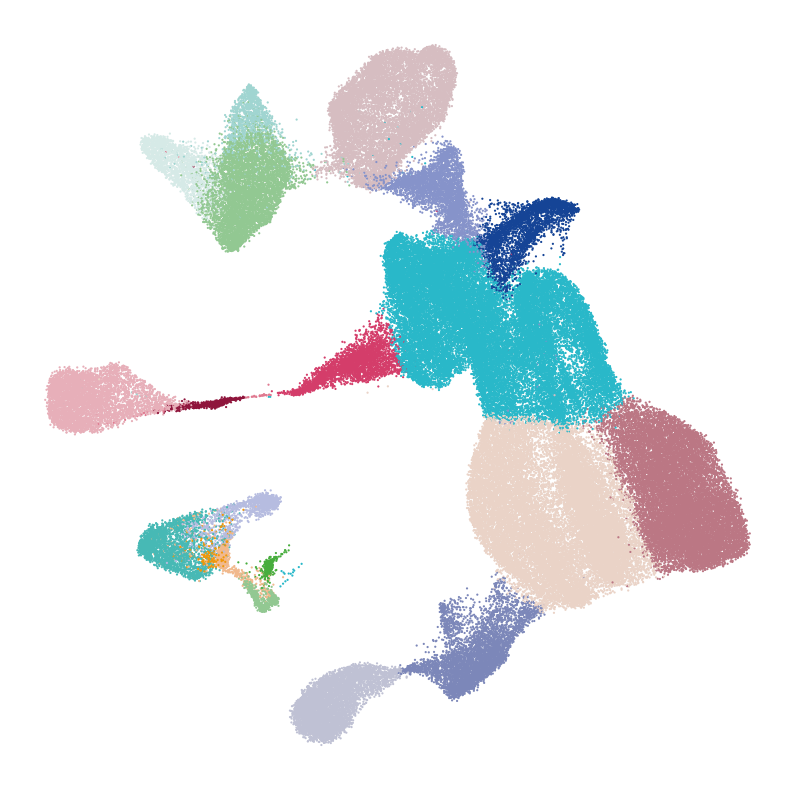

In [36]:
sk.plot_embedding(
    fetal_ms_ad0,
    basis="umap_bk",
    groupby="independent_annotation_refined_20220823",
    size=10,
    figsize=(10, 10),
    title="Fetal skin stroma annotation",
    legend_fontsize=11,
    frameon=False,
    annot=False,
    save="figures/fig3A_color_updated.20220823_notext.pdf",
);

In [37]:
# !rclone copy --drive-shared-with-me figures/fig3A_color_updated.20220823.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'

In [39]:
fetal_ms_ad0.uns

OverloadedDict, wrapping:
	OrderedDict([('independent_annotation_refined_20220823_colors', ['#92C892', '#47AD3D', '#F1B98D', '#B6BCE0', '#47B9B5', '#F09709', '#154496', '#BFC1D4', '#7C87B9', '#8693CA', '#29B8C9', '#BB7784', '#D6BDC1', '#EAD3C7', '#D43D6A', '#8F153C', '#E07A91', '#E7AFB9', '#D6EAE7', '#A0D5D1', '#92C892'])])
With overloaded keys:
	['neighbors'].

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


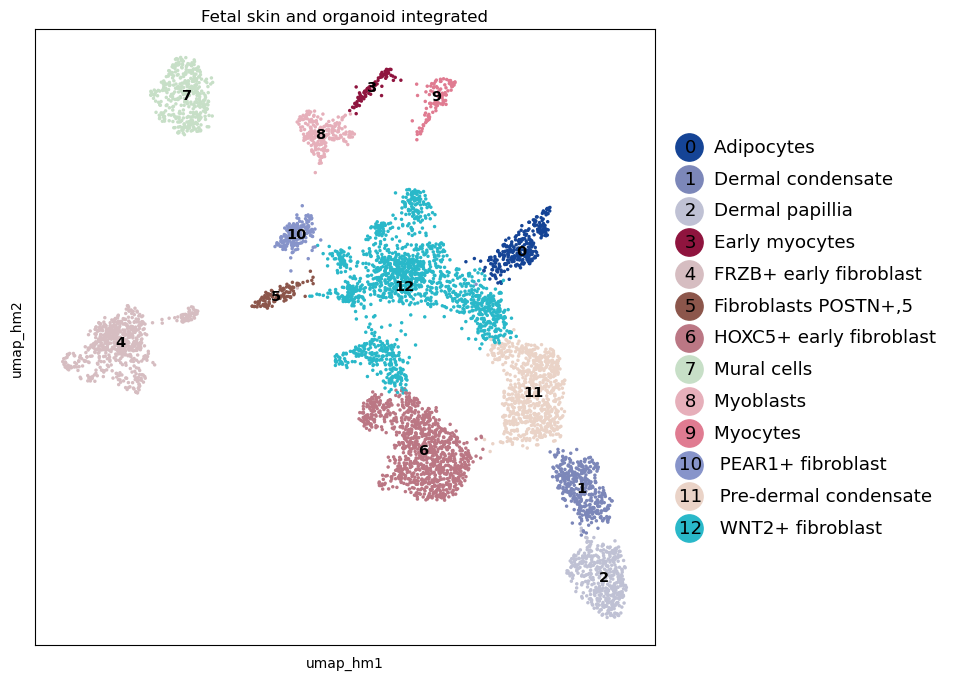

In [40]:
sk.plot_embedding(
    pooled_ms_ad0,
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    figsize=(8, 8),
    save="Pooled_MS.joint_annotation.pdf",
    legend_fontsize=12,
    title="Fetal skin and organoid integrated",
);

/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
/home/jovyan/my-conda-envs/FCA_base/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:365: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


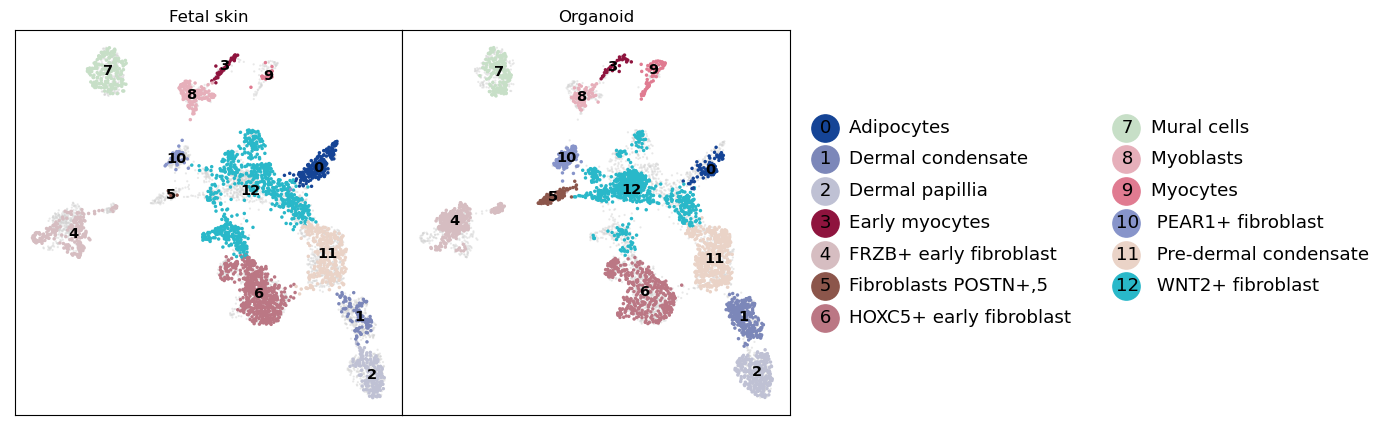

In [41]:
sk.set_figsize((10, 5))
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={"wspace": 0})

sc.pl.embedding(pooled_ms_ad0, basis="umap_hm", size=10, alpha=0.5, show=False, ax=axs[0])
sk.plot_embedding(
    pooled_ms_ad0[pooled_ms_ad0.obs.dataset == "fetal_skin"],
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    legend_fontsize=12,
    legend_loc="none",
    title="Fetal skin",
    ax=axs[0],
    show=False,
)
sc.pl.embedding(pooled_ms_ad0, basis="umap_hm", size=10, alpha=0.5, show=False, ax=axs[1])
sk.plot_embedding(
    pooled_ms_ad0[pooled_ms_ad0.obs.dataset == "organoid"],
    basis="umap_hm",
    groupby="joint_annot2",
    size=25,
    legend_fontsize=12,
    title="Organoid",
    ax=axs[1],
    show=False,
)
axs[0].set_xlabel("")
axs[0].set_ylabel("")
axs[1].set_xlabel("")
axs[1].set_ylabel("")
fig.savefig("figures/fig3B.20220823.pdf", bbox_inches="tight")
gc.collect();

In [81]:
# !rclone copy --drive-shared-with-me figures/fig3B.20220823.pdf 'google:/Fetal Skin/Figures/Figs_from_Ni/'